# 確率的潜在意味スケーリング (PLSS)
LSS を項目反応理論 (IRT) をもとに統計モデルとして確率化したテキストの潜在的な尺度に対応する連続値を扱うことのできるモデル

確率的潜在意味スケーリング (Probabilistic Latent Semantic Scaling)  
http://chasen.org/~daiti-m/paper/nl249plss.pdf

## 項目反応理論 (IRT)
心理統計学の分野で開発された方法論で、テストの結果から被験者の潜在的な能力あるいは傾向 $\theta$ を推定することを目的とする。被験者の $\theta$ は標準正規分布 $\mathcal{N}(0,1)$ に従っていると仮定する。
$$
\theta \sim \mathcal{N}(0, 1) \tag{4}
$$

被験者 $i$ の問題 $j$ 対する正答確率 $p_{ij}$ は次のようにモデル化される。
$$
p_{ij} = \sigma(\alpha_j(\theta_i-\beta_j)) \tag{5}
$$

$\sigma(x)=\frac{1}{1+e^{-x}}$ は、ロジスティック（シグモイド）関数。問 $j$ への正答率は問題の難易度を表す $\beta_j$ を境に、$\alpha_j$ に比例する確率で上昇することを表している。

観測データとして$Y = \{y_{ij}\}_{i,j}$ を考え、$y_{ij}$ は被験者$i$が問 $j$ に正答した時 1, 誤ったときに 0 とすると、$Y$ の確率は下記のようにあらわすことができる。
$$
\begin{align}
p(Y|\alpha, \beta, \theta) &= \prod_i\prod_j Bernoulli (y_{ij}|p_{iij}) \tag{6} \\
&= \prod_i\prod_j Bernoulli (y_{ij}|\sigma(\alpha_j(\theta_i-\beta_j))) \tag{7}
\end{align}
$$

IRT では事前確率 (4) の下で尤度 (7) を最大にするパラメータ ${\alpha_i, \beta_j}$ を求め、同時に被験者の能力 ${\theta_i}$ を推定する。

## PLSS の生成過程
PLSS ではまず式 (5) を多項分布に拡張する形で、テキストにおける単語 $v$ の確率を次のようにモデル化する。
$$
\begin{align}
p(v|\theta,\phi) &\propto p(v)exp(\theta \cdot \phi_v) \tag{8} \\
&= \frac{exp(\log p(v) + \theta \cdot \phi_v)}{\sum^V_{v=1}exp(\log p(v)+\theta \cdot \phi_v)} \tag{9}
\end{align}
$$
Wordfish 同様に $\phi_v \in \mathbb{R}$ は、単語 $v$ の潜在的な極性、$\theta \sim \mathcal{N}(0, 1)$ は、テキストの潜在的な極性を表す。  
このモデルは、IRT の多項分布化、あるいは式 (9) で表される多項ロジスティック回帰において、$\theta$ も $\phi$ も未知の場合の教師なし学習とみなすことができる。

このとき、テキスト $d$ の確率は単語 $v$ のテキスト内での頻度を $n_{dv}$ とおくと
$$
p(d|\theta,\phi) = \prod^V_{v=1} p(v|\theta,\phi)^{n_{dv}} \tag{10}
$$
と書けるので、$D$ 個のテキストからなるコーパス $D$ 全体の確率は、
$$
p(D|\Theta,\phi) = \prod^{D}_{d=1}\prod^{V}_{v=1} p(v|\theta_d,\phi)^{n_{dv}} \tag{11}
$$
と表せる。

式 (11) は、mcmc や最適化でパラメータを推定することが可能だが、$\phi_1,\cdots,\phi_V$ を独立に学習するため、単語間の意味的関係を扱えないという問題がある。
PLSS では、単語極性 $\phi$ をニューラル単語ベクトルを用いて設計する事でこれに対処している。

## 単語極性の設計
PLSS では、を $K$ 次元のニューラル単語ベクトル $\vec{v}$ を用いて、$\phi_v$ を下記の通り計算する。
$$
\phi_v = \boldsymbol{\beta}^T\vec{v}
$$
これにより、各単語の $\phi$ を独立に推定する代わりに $K$ 次元の係数ベクトル $\boldsymbol{\beta}$ を１つ推定するだけでよくなる。 
この $\boldsymbol{\beta}$ は、単語埋め込みベクトル空間における"良い-悪い", "右翼-左翼"のような $\theta$ の極性を与える「意味方向（極性軸）」を表している。  

これによって、式 (9) は、
$$
\begin{align}
p(v|\theta,\boldsymbol{\beta}) &= \frac{exp(\log p(v) + \theta \cdot \boldsymbol{\beta}^T\vec{v})}{\sum^V_{v=1}exp(\log p(v)+\theta \cdot \boldsymbol{\beta}^T\vec{v})} \tag{12}
\end{align}
$$
と表すことができる。  

$\theta$ と $\boldsymbol{\beta}$ を式 (11) に基づいて、教師なしで同時推定することも可能だが、これによって学習される $\boldsymbol{\beta}$ は、Wordfish 同様に分析の目的に一致しているとは限らないとして、より直接的に単語極性の設計している。  

論文では、分析目的の対応した正と負の極性単語集合が与えられた時に、意味方向 $\boldsymbol{\beta}$  を計算する方法として、以下の二つをあげている。

- 超密埋め込み (Ularadense embedding) [DensRay](https://arxiv.org/abs/1904.08654) 
- 単純に負の極性語の平均ベクトルから正の極性語の平均ベクトルへの方向ベクトルを用いる方法

### DensRay による意味方向の設計
＃ ここわかってない

語彙集合 $V := \{v_1, v_2, ..., v_n\}$ とその埋め込み $E \in \mathbb{R}^{n \times d}$ および、言語的特徴アノテーション $l:V \to \{-1,1\}$ が与えられた時に、$EQ$ が解釈可能となるような、直交行列 $Q \in \mathbb{R}^{d \times d}$ を求めることを目的とする。   
これによって求まった、$EQ$ の最初の $k$ 次元を解釈可能な超高密度の単語空間 (interpretable ultradense word space) と呼ぶ。  

DensRay では、言語的信号 $L_=:= \{(v, w) \in V \times V |\; l(v) = l(w)\}$ および $L_{\not =}:= \{(v, w) \in V \times V |\; l(v) {\not =} l(w)\}$ が与えられた上で、[Densifier](https://arxiv.org/abs/1602.07572) を修正した、以下の目的関数について最適化する。

$$
\begin{align}
\max_q \sum _ {(v,w) \in L_{\not =}} \alpha_{\not =} &\left\| q^\intercal d_{vw} \right\| _ { 2 }^2- \nonumber \\
&\sum _ { (v,w) \in L_{=}}  \alpha_{=}  \left\| q^\intercal d_{vw} \right\| _ { 2 }^2 \tag{13}
\end{align}
$$
$d_{vw}:= e_v - e_w$, $e_i$ は、$E$ の $i$番目の行ベクトル。$\text{subject to } q^\intercal q = 1$, $q \in \mathbb{R}^d$. $\alpha_{\not =}, \alpha_{=}  \in [0, 1]$ はハイパーパラメータ。

$\left\|x\right\|_2^2 = x^\intercal x$ と行列積の結合法則を用いると式 (13) は次の通り単純化できる。
$$
\begin{align}
\max_{q}\; & q^\intercal \Big( \alpha_{\not =}  \sum_{(v,w) \in L_{\not =}} d_{vw}d_{vw}^\intercal - \\
&\qquad\qquad \alpha_{=}  \sum_{(v,w) \in L_{=}} d_{vw}d_{vw}^\intercal \Big) q \nonumber \tag{14} \\
& =:\; \max_{q}\; q^\intercal  A q  \quad \text{subject to } q^\intercal q = 1. \nonumber 
\end{align}
$$

これは、$A$ と $q$ のレイリー商を最大化することを指す。$A$ は実対称行列である。このとき $A$ の固有ベクトルを、対応する固有値の大きい順に並べた行列が目的の行列 $Q$ となる。$A$ が実対称行列なので $Q$ は常に直交する。

$k = 1$ としたとき、$Q$ と $EQ$ のそれぞれ 1 次元目が $\boldsymbol{\beta}$ と $\phi$ に対応する。

LSS に付属する以下の標準的な極性辞書を用いて計算された単語の極性値を参考レベルで記載する。  

$$
\begin{align}
S_+ &:= \{'good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior'\} \\
S_\_ &:= \{'bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'\}
\end{align}
$$

### 平均ベクトル間の方向ベクトルによる意味方向の設計
PLSSでは、$S_+$ を正の極性語集合、$S_\_$ は負の極性語集合を使って、次のように単純な計算式で $\boldsymbol{\beta}$ を設計している。$\boldsymbol{\beta}$ のノルムは 1 に正規化する。
$$
\begin{align}
\boldsymbol{\beta} &\propto \left(\frac{1}{|S_+|}\sum_{v \in S_+} \vec{v} - \frac{1}{|S_\_|}\sum_{w \in S_\_} \vec{w} \right)
\end{align}
$$

In [1]:
%load_ext rpy2.ipython

In [2]:
import re
import numpy as np
import pandas as pd
import scipy as sc
import gensim
import gensim.downloader as api

from gensim.models import KeyedVectors
from scipy.stats import norm, uniform, pearsonr
from scipy.optimize import minimize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [3]:
%%R
library(rstan)
library(tidyverse)
library(lubridate)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.2.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


要求されたパッケージ StanHeaders をロード中です
要求されたパッケージ ggplot2 をロード中です
rstan (Version 2.21.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

次のパッケージを付け加えます: ‘gridExtra’

以下のオブジェクトは ‘package:dplyr’ からマスクされています:

    combine

追加情報: 警告メッセージ:
The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the rstan package.
  Please report the issue at <https://github.com/stan-dev/rstan/issues/>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


### 実験資材の準備

In [4]:
# YoungSoroka.2012 を前処理した BoW データをロード
df = pd.read_csv("../data/YS.2012.csv")
df

,Id,doc_id,ys_topic,ys_scale,rate,americans,bought,new,single,family,...,yiddish,peretz,ela,chaim,cunzer,uncle's,masterwork,handwritten,thesis,dissertation
0,1,text1,Economy,2.0,6.0,1.0,1.0,6.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,text2,Economy,3.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,text3,Economy,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,text4,Economy,3.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,text5,Economy,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,text896,Foreign,1.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,897,text897,Foreign,2.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,898,text898,Foreign,3.0,0.0,4.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,899,text899,Foreign,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# BoW を CountVectorizer で調整したいので BoW DataFrame から生トークン列を復元

def restore_tokens(df):
    vocab = df.columns[4:]
    bow = df.iloc[:, 4:]
    docs = []
    with tqdm(total=len(df)) as bar:
        for row in bow.iterrows():
            doc = " ".join([" ".join(int(row[1].iloc[i])*[v]) for i, v in enumerate(vocab)])
            doc = re.sub(r"\s+", " ", doc.strip())
            docs.append(doc)
            bar.update()
    return docs

# トークン列を復元
corpus = restore_tokens(df)
corpus[:3]

100%|██████████| 900/900 [00:36<00:00, 24.56it/s]


['rate rate rate rate rate rate americans bought new new new new new new single single family family homes homes dropped percent percent percent percent percent percent percent percent government today resurging mortgage mortgage mortgage rates rates rates rates rates sharp jump home home home home home home prices apparently deterred potential buyers survey survey survey departments commerce housing urban development estimated estimated estimated estimated sales sales sales sales sales sales sales sales sales sales sales sales seasonally adjusted lower lower revised annual annual annual annual level units units taking actual actual multiplying adjusting normal seasonal patterns also median median price price jumped decline decline x13 totaled totaled first months houses sold sold comparable figure plunged last response soaring interest reached bottom peaked picked came now reverse occurring drop sharpest middle middle west west south south showed xan fell copyright york times company'

In [6]:
#### コーパスから推論に必要な情報を取得

def analyze_corpus(corpus):
    """ コーパスから推論に必要な情報を取得
        Returns:
            BoW: 文書x単語行列（出現頻度）
            word2id: 語彙ID辞書
            vocab: 語彙
            p_v: 単語の出現確率
            D: 文書数
            V: 語彙数
    """

    lowercase=True
    max_df=1.0
    min_df=3
    max_features=None

    cv = CountVectorizer(binary=False, lowercase=lowercase, max_df=max_df, min_df=min_df, max_features=max_features)
    BoW = cv.fit_transform(corpus).toarray()

    word2id = cv.vocabulary_
    vocab = cv.get_feature_names_out()

    D: int = len(corpus)
    V: int = len(vocab)
    N: int = BoW.sum()
    p_v = np.sum(BoW, axis=0)/np.sum(BoW)

    return BoW, word2id, vocab, p_v, D, V

BoW, word2id, vocab, p_v, D, V = analyze_corpus(corpus)
print(f"D={D}, V={V}")

D=900, V=7874


In [7]:
# サイズや学習データの異なる埋め込みモデルをいろいろロード＆保存

#| warning: false
#wv_model = api.load("glove-wiki-gigaword-50")
#wv_model.save("../data/glove-wiki-gigaword-50.model")

#wv_model = api.load("glove-wiki-gigaword-300")
#wv_model.save("../data/glove-wiki-gigaword-300.model")

# Err. ContentTooShortError: <urlopen error retrieval incomplete: got only 608174080 out of 1743563840 bytes>
##wv_model = api.load("word2vec-google-news-300")

In [8]:
# wa. ContentTooShortError: <urlopen error retrieval incomplete: got only 608174080 out of 1743563840 bytes>
#!curl -L -o ../data/word2vec-google-news-300.model "https://huggingface.co/fse/word2vec-google-news-300/resolve/main/word2vec-google-news-300.model?download=true"
#!curl -L -o ../data/word2vec-google-news-300.model.vectors.npy "https://huggingface.co/fse/word2vec-google-news-300/resolve/main/word2vec-google-news-300.model.vectors.npy?download=true"

### 単語極性φの計算

In [9]:
# 意味方向ベクトルを計算するための単語埋め込みモデル
wv_model = KeyedVectors.load("../data/glove-wiki-gigaword-300.model")

In [10]:
# 意味方向ベクトルを計算するためのシード単語 (S_+, S_-)
pos_words = ['good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior']
neg_words = ['bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior']

#### DenseRay

In [11]:
import logging
log = logging.getLogger()

from densray.data import Embeddings, Lexicon
from densray.model import DensRay, LexIndPredictor

def get_densray_phi(pos_words, neg_words, wv, vocab):
  lex_version = "countable"
  
  # train
  embeds = Embeddings(log)
  embeds.load_from_gensim(wv)
  
  Ltrain = Lexicon(log)
  Ltrain.load_binary(pos_words, neg_words, lex_version)
  Ltrain.remove_inconsistencies(remove_all=True)
  Ltrain.binarise()
  
  embeds.filter(set([k for k, v in Ltrain.L[lex_version]]))
  embeds.normalize()
  
  weights = 0.5,0.5
  normalize_D = True
  normalize_labels = False
  
  dr = DensRay(log, embeds, Ltrain)
  dr.fit(weights=weights, model="binary", normalize_D=normalize_D, normalize_labels=normalize_labels)
  
  T = dr.T
  
  embeds = Embeddings(log)
  embeds.load_from_gensim(wv)
  embeds.filter(set(vocab))
  embeds.normalize()
  
  pred_method = "first_dimension"
  dim_weights = None
  
  pred = LexIndPredictor(log, embeds, vocab, T)
  pred.predict(pred_method, dim_weights=dim_weights)
  
  return pred.predictions

dr_phi = get_densray_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [12]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(dr_phi, key=lambda x: x[1], reverse=True)][:20]))

blamed              	0.3743
mired               	0.3614
unnecessarily       	0.3545
caused              	0.3506
abusive             	0.3477
bad                 	0.3440
mismanagement       	0.3355
needlessly          	0.3355
worsening           	0.3346
blame               	0.3345
horrible            	0.3318
worse               	0.3318
unfortunate         	0.3298
irresponsible       	0.3288
appalling           	0.3248
consequences        	0.3244
plagued             	0.3244
beset               	0.3239
disastrous          	0.3205
unnecessary         	0.3203


極性 $\phi_v < 0$ の下位単語

In [13]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(dr_phi, key=lambda x: x[1])][:20]))

excellent           	-0.4745
impressive          	-0.3322
solid               	-0.3294
superb              	-0.3250
nice                	-0.3210
terrific            	-0.3109
enjoyed             	-0.3068
enjoy               	-0.3060
enjoying            	-0.3030
good                	-0.3006
confident           	-0.2971
restored            	-0.2848
perfect             	-0.2780
reasonably          	-0.2771
provides            	-0.2770
offers              	-0.2760
achieved            	-0.2751
pleased             	-0.2694
robust              	-0.2692
remarkable          	-0.2658


#### PLSS 意味方向ベクトル

In [14]:
def get_plss_phi(pos_words, neg_words, wv, vocab):
    """ 両極のシード単語群から得られる２つの平均ベクトルから意味方向ベクトルを計算
    """

    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index

    def calc_beta(pos_words, neg_words):
        def mean_vec(words):
            return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)

        beta = mean_vec(pos_words) - mean_vec(neg_words)
        beta = beta/np.linalg.norm(beta)
        return beta

    beta = calc_beta(pos_words, neg_words)
    phi = [(v, beta @ normed_vec[key2index[v]] if v in key2index else 0) for v in vocab]
    return phi

# 単語極性の計算
plss_phi = get_plss_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [15]:
for word, polarity in sorted(plss_phi, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

excellent           	0.4895
superb              	0.3367
impressive          	0.3362
solid               	0.3260
terrific            	0.3059
nice                	0.3041
enjoyed             	0.2998
enjoy               	0.2943
enjoying            	0.2931
restored            	0.2898
provides            	0.2849
good                	0.2833
confident           	0.2829
offers              	0.2809
reasonably          	0.2753
perfect             	0.2741
achieved            	0.2726
guide               	0.2695
impressed           	0.2649
robust              	0.2631


極性 $\phi_v < 0$ の下位単語

In [16]:
for word, polarity in sorted(plss_phi, key=lambda x: x[1])[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

blamed              	-0.3683
mired               	-0.3641
unnecessarily       	-0.3600
abusive             	-0.3547
caused              	-0.3482
bad                 	-0.3440
needlessly          	-0.3399
unfortunate         	-0.3375
worse               	-0.3356
horrible            	-0.3353
worsening           	-0.3330
irresponsible       	-0.3327
blame               	-0.3317
consequences        	-0.3278
beset               	-0.3238
mismanagement       	-0.3237
messy               	-0.3234
appalling           	-0.3203
plagued             	-0.3202
worsen              	-0.3200


#### コサイン類似度による意味方向の計算
＃論文には書かれていないが、ナイーブな設計としてコサイン類似度を用いる方法

In [17]:
def get_cos_phi(pos_words, neg_words, wv, vocab):
    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index

    def mean_vec(words):
        return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)

    pos_vec = mean_vec(pos_words)
    neg_vec = mean_vec(neg_words)

    pos_score = normed_vec @ pos_vec
    neg_score = normed_vec @ neg_vec
    phi = (-neg_score + pos_score)/2

    v_phi = [(v, phi[key2index[v]] if v in key2index else 0) for v in vocab]

    return v_phi

In [18]:
cos_phi = get_cos_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [19]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(cos_phi, key=lambda x: x[1], reverse=True)][:20]))

excellent           	0.1273
superb              	0.0876
impressive          	0.0874
solid               	0.0848
terrific            	0.0795
nice                	0.0791
enjoyed             	0.0780
enjoy               	0.0765
enjoying            	0.0762
restored            	0.0754
provides            	0.0741
good                	0.0737
confident           	0.0736
offers              	0.0730
reasonably          	0.0716
perfect             	0.0713
achieved            	0.0709
guide               	0.0701
impressed           	0.0689
robust              	0.0684


極性 $\phi_v < 0$ の下位単語

In [20]:
print("\n".join([f"{e[0].ljust(20)}\t{e[1]:>5,.4f}" for e in sorted(cos_phi, key=lambda x: x[1])][:20]))

blamed              	-0.0958
mired               	-0.0947
unnecessarily       	-0.0936
abusive             	-0.0922
caused              	-0.0906
bad                 	-0.0895
needlessly          	-0.0884
unfortunate         	-0.0878
worse               	-0.0873
horrible            	-0.0872
worsening           	-0.0866
irresponsible       	-0.0865
blame               	-0.0863
consequences        	-0.0853
beset               	-0.0842
mismanagement       	-0.0842
messy               	-0.0841
appalling           	-0.0833
plagued             	-0.0833
worsen              	-0.0832


#### 各単語埋め込みモデルと意味方向の設計について単語極性 φ を計算

In [21]:
def get_phi_val(v_phi):
  # φ のみを取り出す
  return np.array([phi for v, phi in v_phi])

wv_model = KeyedVectors.load("../data/glove-wiki-gigaword-50.model")
phi_dr_giga50 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_giga50 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_giga50 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

wv_model = KeyedVectors.load("../data/glove-wiki-gigaword-300.model")
phi_dr_giga300 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_giga300 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_giga300 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

wv_model = gensim.models.KeyedVectors.load("../data/word2vec-google-news-300.model")
phi_dr_gnews300 = get_phi_val(get_densray_phi(pos_words, neg_words, wv_model, vocab))
phi_plss_gnews300 = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))
phi_cos_gnews300 = get_phi_val(get_cos_phi(pos_words, neg_words, wv_model, vocab))

### 文書極性 θ の推論

In [22]:
# Python変数をRに渡す
%R -i D,V,BoW,p_v
%R -i phi_plss_giga300

In [23]:
%%R
data <- list(
  D=D,
  V=V,
  BoW=BoW,
  p_v=p_v,
  phi=phi_plss_giga300
)

In [24]:
%%R
stanmodel <- stan_model(file="./plss.stan")

#### MAP推定

In [25]:
%%R
# MAP推定 (optimizing)
fit <- optimizing(stanmodel, data=data, seed=1234, verbose=TRUE)

# 結果を確認
theta <- fit$par[grep("theta", names(fit$par))]
print(paste("theta の長さ:", length(theta)))
print(paste("theta の範囲:", round(min(theta), 3), "〜", round(max(theta), 3)))

Chain 1: Initial log joint probability = -1.44851e+06
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:        9  -1.44497e+06     0.0793513     0.0621198           1           1       13   
Chain 1: Optimization terminated normally: 
Chain 1:   Convergence detected: relative gradient magnitude is below tolerance
[1] "theta の長さ: 900"
[1] "theta の範囲: -3.781 〜 5.593"


[1] "相関係数: 0.368"


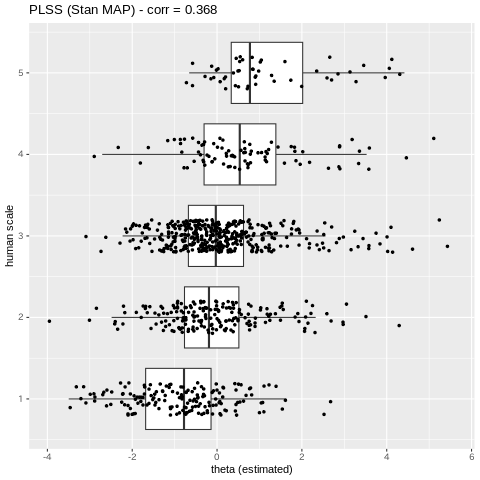

In [26]:
%%R
# 人手評価との相関を計算
library(tidyverse)

# 人手評価データをロード
ys <- read.csv("../data/YS.2012.csv")

# 相関係数を計算
correlation <- cor(theta, ys$ys_scale, method="pearson")
print(paste("相関係数:", round(correlation, 4)))

# 可視化
result <- tibble(
  scale = ys$ys_scale,
  theta = theta
)

ggplot(data = result, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot(outlier.colour = NA) +
  geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
  labs(title = paste("PLSS (Stan MAP) - corr =", round(correlation, 3)),
       x = "theta (estimated)",
       y = "human scale")

#### MCMC

In [27]:
%%R
# MCMC推定（遅すぎた。。。）
#fit_mcmc <- sampling(
#  stanmodel, 
#  data=data, 
#  seed=1234,
#  chains=3,
#  iter=1000,
#  warmup=500,
#  cores=3
#)

# 結果の要約
#print(fit_mcmc, pars="theta", probs=c(0.025, 0.5, 0.975))

NULL
